<a href="https://colab.research.google.com/github/Annrosejojue/News-Recommendation/blob/main/News_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>PERSONALIZED NEWS RECOMMENDATION SYSTEM</h1>

# Importing necessary libraries for data handling, visualization, and machine learning

In [33]:
!pip install scikit-surprise


In [34]:
!pip install --upgrade pip
!pip install scikit-surprise --no-binary scikit-surprise


In [35]:
!pip install numpy==1.26.4


In [36]:
!pip install gensim

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader
from surprise import SVD, KNNBasic
from gensim.models import Word2Vec
import tensorflow as tf
import gc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, LSTM, Dense, Dot, Activation
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from surprise.model_selection import train_test_split as surprise_split
from surprise import accuracy
from sklearn.metrics import roc_auc_score, average_precision_score, ndcg_score
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Load the news dataset with predefined column names

In [38]:
news_columns = [
    'news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'
]

In [39]:
news = pd.read_csv('/content/news.tsv', sep='\t', names=news_columns)

In [40]:
news.head()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [41]:
news.tail()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
51277,N16909,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...,https://assets.msn.com/labs/mind/BBWzQJK.html,"[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid...","[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid..."
51278,N47585,lifestyle,lifestylefamily,Family says 13-year-old Broadway star died fro...,NaN,https://assets.msn.com/labs/mind/BBWzQYV.html,"[{""Label"": ""Broadway theatre"", ""Type"": ""F"", ""W...",[]
51279,N7482,sports,more_sports,St. Dominic soccer player tries to kick cancer...,"Sometimes, what happens on the sidelines can b...",https://assets.msn.com/labs/mind/BBWzQnK.html,[],[]
51280,N34418,sports,soccer_epl,How the Sounders won MLS Cup,"Mark, Jeremiah and Casey were so excited they ...",https://assets.msn.com/labs/mind/BBWzQuK.html,"[{""Label"": ""MLS Cup"", ""Type"": ""U"", ""WikidataId...",[]
51281,N44276,autos,autossports,Best Sports Car Deals for October,NaN,https://assets.msn.com/labs/mind/BBy5rVe.html,"[{""Label"": ""Peugeot RCZ"", ""Type"": ""V"", ""Wikida...",[]


In [42]:
news.shape

(51282, 8)

In [43]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   news_id            51282 non-null  object
 1   category           51282 non-null  object
 2   subcategory        51282 non-null  object
 3   title              51282 non-null  object
 4   abstract           48616 non-null  object
 5   url                51282 non-null  object
 6   title_entities     51279 non-null  object
 7   abstract_entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


# Load user behavior dataset (impressions, clicks, history)

In [44]:
behaviors_columns = [
    'impression_id', 'user_id', 'time', 'history', 'impressions'
]

In [45]:
behaviors = pd.read_csv('/content/behaviors.tsv', sep='\t', names=behaviors_columns)

In [46]:
behaviors.head()

,impression_id,user_id,time,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [47]:
behaviors.tail()

,impression_id,user_id,time,history,impressions
156960,156961,U21593,11/14/2019 10:24:05 PM,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...
156961,156962,U10123,11/13/2019 6:57:04 AM,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...
156962,156963,U75630,11/14/2019 10:58:13 AM,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...
156963,156964,U44625,11/13/2019 2:57:02 PM,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...
156964,156965,U64800,11/14/2019 3:25:49 PM,N22997 N48742,N61233-0 N33828-1 N19661-0 N41934-0


In [48]:
behaviors.shape

(156965, 5)

In [49]:
behaviors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156965 entries, 0 to 156964
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   impression_id  156965 non-null  int64 
 1   user_id        156965 non-null  object
 2   time           156965 non-null  object
 3   history        153727 non-null  object
 4   impressions    156965 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.0+ MB


In [50]:
news.isnull().sum()

,0
news_id,0
category,0
subcategory,0
title,0
abstract,2666
url,0
title_entities,3
abstract_entities,4


In [51]:
behaviors.isnull().sum()

,0
impression_id,0
user_id,0
time,0
history,3238
impressions,0


# Handle missing values in text fields by replacing them with empty strings

In [52]:
news['abstract'] = news['abstract'].fillna('')

In [53]:
behaviors['history'] = behaviors['history'].fillna('')

# Combine title and abstract into a single text field for content-based filtering

In [54]:
news['full_text'] = news['title'] + ' ' + news['abstract']

In [55]:
news['category'].value_counts()

,count
category,
news,15774
sports,14510
finance,3107
foodanddrink,2551
lifestyle,2479
travel,2350
video,2068
weather,2048
health,1885


In [56]:
news['category'].nunique()

17

In [57]:
news['subcategory'].value_counts()

,count
subcategory,
newsus,6564
football_nfl,5420
newspolitics,2826
newscrime,2254
weathertopstories,2047
...,...
newsvideo,1
travel,1
lifestylehoroscopefish,1


In [58]:
news['subcategory'].nunique()

264

In [59]:
behaviors['user_id'].value_counts()

,count
user_id,
U32146,62
U15740,44
U20833,41
U51286,40
U44201,40
...,...
U60416,1
U20588,1
U84385,1


In [60]:
behaviors['user_id'].nunique()

50000

# Visualize distribution of news categories

/tmp/ipython-input-1497813024.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='category', data=news, order=news['category'].value_counts().index, palette='viridis')


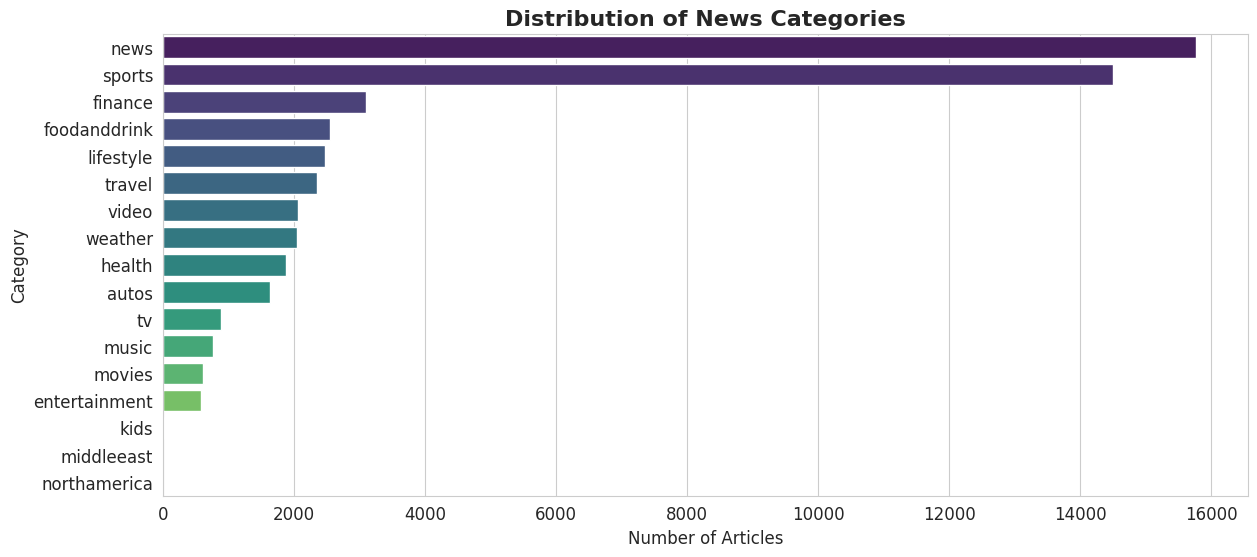

In [61]:
plt.figure(figsize=(14, 6))
sns.countplot(y='category', data=news, order=news['category'].value_counts().index, palette='viridis')
plt.title('Distribution of News Categories', fontsize=16, fontweight='bold')
plt.xlabel('Number of Articles')
plt.ylabel('Category')
plt.show()

/tmp/ipython-input-2802514530.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='subcategory', data=news[news['subcategory'].isin(top_subcats)], order=top_subcats, palette='magma')


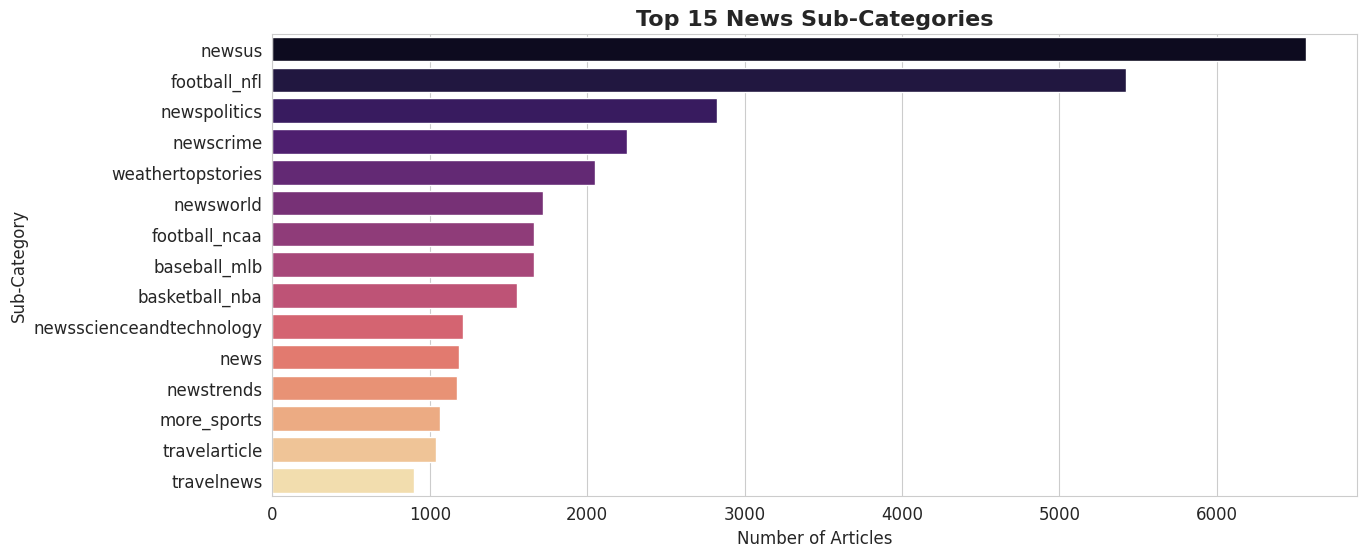

In [62]:
plt.figure(figsize=(14, 6))
top_subcats = news['subcategory'].value_counts().nlargest(15).index
sns.countplot(y='subcategory', data=news[news['subcategory'].isin(top_subcats)], order=top_subcats, palette='magma')
plt.title('Top 15 News Sub-Categories', fontsize=16, fontweight='bold')
plt.xlabel('Number of Articles')
plt.ylabel('Sub-Category')
plt.show()

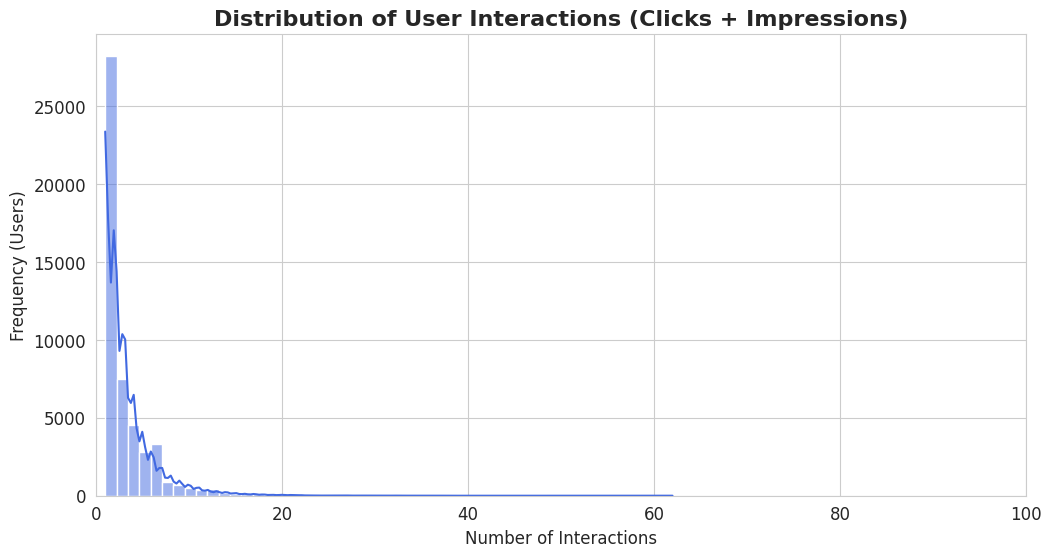

In [63]:
user_interaction_counts = behaviors['user_id'].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(user_interaction_counts, bins=50, kde=True, color='royalblue')
plt.title('Distribution of User Interactions (Clicks + Impressions)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency (Users)')
plt.xlim(0, 100)
plt.show()

TypeError: asarray() got an unexpected keyword argument 'copy'

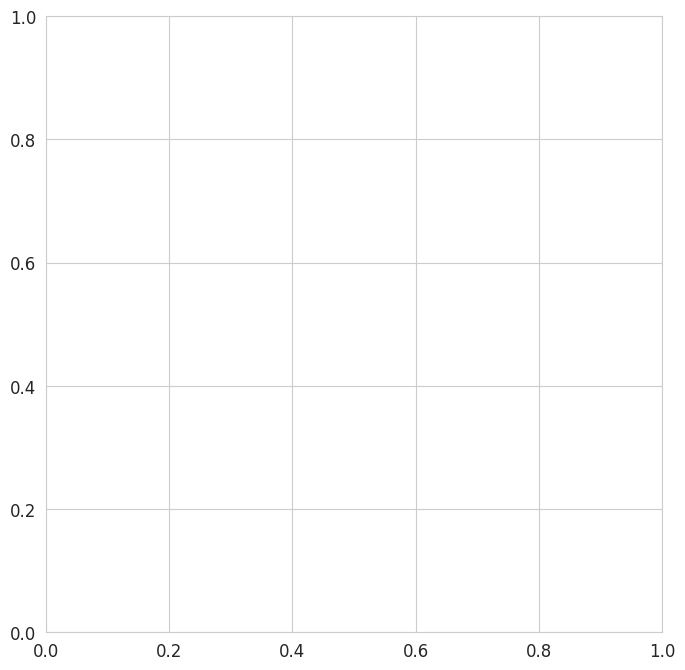

In [64]:
text = " ".join(title for title in news['title'])
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap='plasma').generate(text)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent Words in News Titles', fontsize=20, fontweight='bold', pad=20)
plt.show()

# Parse user interactions: split impressions into clicked/not clicked articles

In [ ]:
parsed_interactions = []
for index, row in tqdm(behaviors.iterrows(), total=behaviors.shape[0]):
    user_id = row['user_id']
    time = row['time']
    history = row['history']
    impression_list = row['impressions'].split()
    for impression in impression_list:
        parts = impression.split('-')
        news_id = parts[0]
        clicked = int(parts[1])
        parsed_interactions.append(
            {
                'user_id': user_id,
                'news_id': news_id,
                'clicked': clicked,
                'time': time,
                'history': history
            }
        )

In [ ]:
interacions = pd.DataFrame(parsed_interactions)

In [ ]:
interacions.head()

In [ ]:
interacions.shape

In [ ]:
interacions['time'] = pd.to_datetime(interacions['time'], format='%m/%d/%Y %I:%M:%S %p')

In [ ]:
interacions.sort_values(by='time', inplace=True)

In [ ]:
interacions.reset_index(drop=True, inplace=True)

In [ ]:
interacions.head()

In [ ]:
interacions.tail()

In [ ]:
split = int(len(interacions)*0.8)

In [ ]:
train = interacions.iloc[:split]
test = interacions.iloc[split:]

In [ ]:
len(interacions)

In [ ]:
len(train)

In [ ]:
len(test)

In [ ]:
train['clicked'].value_counts(normalize=True)

In [ ]:
train_positives = train[train['clicked'] == 1]
train_negatives = train[train['clicked'] == 0]

In [ ]:
num_positives = len(train_positives)

In [ ]:
num_positives

In [ ]:
len(train_negatives)

In [ ]:
train_negatives_sampled = train_negatives.sample(n=num_positives, random_state=42)

In [ ]:
train_balanced = pd.concat([train_positives, train_negatives_sampled])
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
len(train_balanced)

In [ ]:
train = train_balanced.copy()

In [ ]:
train['clicked'].value_counts(normalize=True)

## POPULARITY BASED RECOMMENDER (Baseline)

# Build a popularity-based recommender (baseline model)
# Count how many times each article was clicked

In [ ]:
popular_articles = train[train['clicked'] == 1]['news_id'].value_counts()

In [ ]:
popular_articles_data = popular_articles.reset_index()

In [ ]:
popular_articles_data.columns = ['news_id', 'click_count']

In [ ]:
popular_articles_data.head()

In [ ]:
test_with_popularity = test.merge(popular_articles_data, on='news_id', how='left')

In [ ]:
test_with_popularity['click_count'] = test_with_popularity['click_count'].fillna(0)

In [ ]:
test_with_popularity[['user_id', 'news_id', 'clicked', 'click_count']].head()

In [ ]:
evaluation_results = {}

In [ ]:
def calculate_metrics(group):
    if len(group['clicked'].unique()) < 2:
        return np.nan, np.nan, np.nan

    y_true = group['clicked'].values
    y_score = group['score'].values

    k_5 = min(5, len(y_true))
    k_10 = min(10, len(y_true))

    y_true_2d = [y_true]
    y_score_2d = [y_score]

    auc = roc_auc_score(y_true, y_score)
    map_score = average_precision_score(y_true, y_score)

    ndcg_at_5 = ndcg_score(y_true_2d, y_score_2d, k=k_5)
    ndcg_at_10 = ndcg_score(y_true_2d, y_score_2d, k=k_10)

    return auc, map_score, ndcg_at_5, ndcg_at_10

In [ ]:
pop_test_df = test_with_popularity.rename(columns={'click_count': 'score'})

In [ ]:
pop_metrics = pop_test_df.groupby(['user_id', 'time']).apply(calculate_metrics)

In [ ]:
pop_metrics.dropna(inplace=True)

In [ ]:
pop_metrics_data = pd.DataFrame(pop_metrics.tolist(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [ ]:
evaluation_results['Popularity'] = pop_metrics_data.mean()

In [ ]:
evaluation_results

## CONTENT-BASED FILTERING

### TF-IDF

# Content-based filtering using TF-IDF
# Represent articles as vectors based on their text content

In [ ]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=20000,
    min_df=5
)

In [ ]:
tfidf_data = tfidf.fit_transform(news['full_text'])

In [ ]:
tfidf_data.shape

In [ ]:
news_id_to_index = pd.Series(news.index, index=news['news_id'])

In [ ]:
sample_user_id = train['user_id'].iloc[0]

In [ ]:
user_history_ids = train[
    (train['user_id'] == sample_user_id) & (train['clicked'] == 1)
]['news_id'].unique()

In [ ]:
sample_user_id

In [ ]:
if len(user_history_ids) > 0:
    last_liked_article_id = user_history_ids[-1]
    last_liked_article_index = news_id_to_index[last_liked_article_id]
    article_vector = tfidf_data[last_liked_article_index]
    cosine = cosine_similarity(article_vector, tfidf_data)

    similar_article_scores = list(enumerate(cosine[0]))
    sorted_scores = sorted(similar_article_scores, key=lambda x: x[1], reverse=True)[1:11]

    similar_article_indices = [i[0] for i in sorted_scores]
    recommended_news_ids = news.iloc[similar_article_indices]['news_id']

    print('Last liked article: ', last_liked_article_id)
    print('Recommendations:\n', recommended_news_ids)
else:
    print(f'User {sample_user_id} has no click history in train set.')


In [ ]:
tqdm.pandas(desc='Calculating Content Scores')

In [ ]:
def calculate_content_score(row):
    history_ids = row['history'].split()
    candidate_id = row['news_id']
    if not history_ids:
        return 0.0
    history_indices = [news_id_to_index.get(nid) for nid in history_ids]
    history_indices = [i for i in history_indices if i is not None]
    if not history_indices:
        return 0.0
    history_vectors = tfidf_data[history_indices]
    user_profile = np.asarray(np.mean(history_vectors, axis=0))
    candidate_index = news_id_to_index.get(candidate_id)
    if candidate_index is None:
        return 0.0
    candidate_vector = tfidf_data[candidate_index]
    score = cosine_similarity(user_profile, candidate_vector)[0][0]
    return score

In [ ]:
cb_test_data = test.copy()

In [ ]:
cb_test_data['score'] = cb_test_data.progress_apply(calculate_content_score, axis=1)

In [ ]:
cb_metrics = cb_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)

In [ ]:
cb_metrics.dropna(inplace=True)

In [ ]:
cb_metrics_data = pd.DataFrame(cb_metrics.tolist(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [ ]:
cb_mean_metrics = cb_metrics_data.mean()

In [ ]:
cb_mean_metrics

# Evaluate models using metrics: AUC, MAP, NDCG@5, NDCG@10
# These metrics measure ranking quality and recommendation relevance

In [ ]:
evaluation_results['Content-Based'] = cb_mean_metrics

In [ ]:
evaluation_results

### Word2Vec

# Here we use Word2Vec to learn vector representations of words from article text.
# This allows us to capture semantic meaning (similar words have similar vectors).
# Later, we can use these vectors to represent entire articles and recommend similar ones.

In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\w\s', '', text)
    return text.split()

# Tokenize the full text of articles for Word2Vec training

In [ ]:
tokenized_text = news['full_text'].apply(preprocess)

In [ ]:
vector_size = 100

In [ ]:
word2vec_model = Word2Vec(
    sentences=tokenized_text,
    vector_size=vector_size,
    window=5,
    min_count=5,
    workers=4
)

# Function to get an article vector by averaging word embeddings
# If an article contains multiple words, we compute the mean of their vectors.
# This gives us a fixed-length representation for each article.

In [ ]:
def get_article_vector(tokens, model, vector_size):
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not word_vectors:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

In [ ]:
article_vectors_w2v = np.array(
    [get_article_vector(doc, word2vec_model, vector_size) for doc in tokenized_text]
)

In [ ]:
def calculate_content_score_w2v(row):
    history_ids = row['history'].split()
    candidate_id = row['news_id']
    if not history_ids:
        return 0.0
    history_indices = [news_id_to_index.get(nid) for nid in history_ids]
    history_indices = [i for i in history_indices if i is not None]
    if not history_indices:
        return 0.0
    history_vectors = article_vectors_w2v[history_indices]
    user_profile = np.mean(history_vectors, axis=0)
    candidate_index = news_id_to_index.get(candidate_id)
    if candidate_index is None:
        return 0.0
    candidate_vector = article_vectors_w2v[candidate_index]
    score = cosine_similarity(user_profile.reshape(1, -1), candidate_vector.reshape(1, -1))[0][0]
    return score

In [ ]:
cb_w2v_test = test.copy()

In [ ]:
cb_w2v_test['score'] = cb_w2v_test.progress_apply(calculate_content_score_w2v, axis=1)

In [ ]:
cb_w2v_metrics = cb_w2v_test.groupby(['user_id', 'time']).apply(calculate_metrics)

In [ ]:
cb_w2v_metrics.dropna(inplace=True)

In [ ]:
cb_w2v_metrics_data = pd.DataFrame(cb_w2v_metrics.tolist(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [ ]:
cb_w2v_mean_metrics = cb_w2v_metrics_data.mean()

In [ ]:
cb_w2v_mean_metrics

In [ ]:
evaluation_results['Content-Based (W2V)'] = cb_w2v_mean_metrics

In [ ]:
evaluation_results

## COLLABORATIVE FILTERING

### SVD

# We now implement a collaborative filtering approach using Singular Value Decomposition (SVD).
# Unlike popularity or content-based methods, SVD learns latent factors from user-item interactions.

In [ ]:
reader = Reader(rating_scale=(0, 1))

In [ ]:
svd_train_data = Dataset.load_from_df(
    train[['user_id', 'news_id', 'clicked']],
    reader
)

In [ ]:
trainset = svd_train_data.build_full_trainset()

In [ ]:
model_svd = SVD(
    n_factors = 100,
    n_epochs = 20,
    lr_all = 0.005,
    reg_all = 0.02,
    verbose = True
)

In [ ]:
model_svd.fit(trainset)

In [ ]:
sample_test_interaction = test.iloc[0]

In [ ]:
user_id = sample_test_interaction['user_id']
news_id = sample_test_interaction['news_id']
true_click = sample_test_interaction['clicked']

In [ ]:
prediction = model_svd.predict(uid=user_id, iid=news_id)

In [ ]:
print(f'User: {user_id} on {news_id}: ')
print(f'Predicted click probability: {prediction}')
print(f'True Click: {true_click}')

In [ ]:
svd_scores = []
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    prediction = model_svd.predict(uid=row['user_id'], iid=row['news_id'])
    svd_scores.append(prediction.est)

In [ ]:
svd_test_data = test.copy()

In [ ]:
svd_test_data['score'] = svd_scores

In [ ]:
svd_metrics = svd_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)

In [ ]:
svd_metrics.dropna(inplace=True)

In [ ]:
svd_metrics_data = pd.DataFrame(svd_metrics.to_list(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [ ]:
svd_mean_metrics = svd_metrics_data.mean()

In [ ]:
svd_mean_metrics

In [ ]:
evaluation_results['SVD'] = svd_mean_metrics

In [ ]:
evaluation_results

In [ ]:
pd.DataFrame(evaluation_results).T

## HYBRID NEURAL MODEL

# In this section, we combine content-based features (text embeddings) with collaborative signals (user interactions).
# The hybrid approach leverages both article text (via embeddings) and user behavior (click history).
# This allows the model to learn richer representations and provide more personalized recommendations.

In [ ]:
vector_size = 100

In [ ]:
max_history_length = 20

In [ ]:
batch_size = 1024

In [ ]:
original_w2v_matrix = article_vectors_w2v

In [ ]:
num_articles = original_w2v_matrix.shape[0]

In [ ]:
embedding_matrix = np.zeros((num_articles + 1, vector_size))

In [ ]:
embedding_matrix[1:] = original_w2v_matrix

In [ ]:
original_w2v_matrix.shape

In [ ]:
embedding_matrix.shape

In [ ]:
news_id_to_index_padded = {
    news_id: index + 1 for news_id, index in news_id_to_index.items()
}

In [ ]:
def create_sequences(df, padded_index, max_len):
    histories = []
    candidates = []
    labels = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Creating Sequences"):
        history_ids = row['history'].split()
        history_indices = [padded_index.get(nid) for nid in history_ids if padded_index.get(nid) is not None]
        padded_history = pad_sequences([history_indices], maxlen=max_len, padding='pre', truncating='pre')[0]
        candidate_index = padded_index.get(row['news_id'])
        label = row['clicked']
        if candidate_index is not None:
            histories.append(padded_history)
            candidates.append(candidate_index)
            labels.append(label)
    return np.array(histories), np.array(candidates), np.array(labels)

In [ ]:
X_train_hist, X_train_cand, y_train = create_sequences(
    train,
    news_id_to_index_padded,
    max_history_length
)

In [ ]:
X_test_hist, X_test_cand, y_test = create_sequences(
    test,
    news_id_to_index_padded,
    max_history_length
)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"History_Input": X_train_hist, "Candidate_Input": X_train_cand},
        y_train
    )
)

In [ ]:
num_train_samples = len(X_train_hist)

In [ ]:
num_val_samples = int(num_train_samples * 0.1)

In [ ]:
num_train_only_samples = num_train_samples - num_val_samples

In [ ]:
train_dataset = train_dataset.shuffle(num_train_samples, reshuffle_each_iteration=False)

In [ ]:
train_pipeline = (
    train_dataset.take(num_train_only_samples)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_pipeline = (
    train_dataset.skip(num_train_only_samples)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
test_pipeline = tf.data.Dataset.from_tensor_slices(
    (
        {"History_Input": X_test_hist, "Candidate_Input": X_test_cand},
        y_test
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
num_train_only_samples

In [ ]:
num_val_samples

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
article_embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=True
)

In [ ]:
history_input = Input(shape=(max_history_length,), name="History_Input")

In [ ]:
candidate_input = Input(shape=(1,), name="Candidate_Input")

In [ ]:
history_vectors = article_embedding_layer(history_input)

In [ ]:
candidate_vector_sequential = article_embedding_layer(candidate_input)

In [ ]:
candidate_vector = tf.keras.layers.Flatten()(candidate_vector_sequential)

### Simple RNN

In [ ]:
rnn_output = SimpleRNN(vector_size, name="RNN_Encoder")(history_vectors)

In [ ]:
dot_product = Dot(axes=1, name="Dot_Product")([rnn_output, candidate_vector])

In [ ]:
dot_product = tf.keras.layers.Flatten()(dot_product)

In [ ]:
output = Activation('sigmoid', name="Click_Probability")(dot_product)

In [ ]:
model = Model(inputs=[history_input, candidate_input], outputs=[output])

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['auc']
)

In [ ]:
model.summary()

In [ ]:
len(tf.config.list_physical_devices('GPU'))

In [ ]:
history = model.fit(
    train_pipeline,
    epochs=5,
    validation_data = val_pipeline,
    verbose=1
)

In [ ]:
def plot_training_history(history, model_name):
    acc = history.history['auc']
    val_acc = history.history['val_auc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-o', label='Training AUC')
    plt.plot(epochs, val_acc, 'r-o', label='Validation AUC')
    plt.title(f'{model_name}: Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title(f'{model_name}: Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_history(history, "Hybrid RNN")

In [ ]:
rnn_scores = model.predict(
    test_pipeline.map(lambda x, y: x),
    verbose=1
)

In [ ]:
test_indices_with_valid_candidates = [
    idx for idx, row in test.iterrows()
    if news_id_to_index_padded.get(row['news_id']) is not None
]

In [ ]:
rnn_test_data = test.loc[test_indices_with_valid_candidates].copy()

In [ ]:
rnn_test_data['score'] = rnn_scores.flatten()

In [ ]:
rnn_metrics = rnn_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)

In [ ]:
rnn_metrics.dropna(inplace=True)

In [ ]:
rnn_metrics_data = pd.DataFrame(rnn_metrics.tolist(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [ ]:
rnn_mean_metrics = rnn_metrics_data.mean()

In [ ]:
rnn_mean_metrics

In [ ]:
evaluation_results['Hybrid RNN'] = rnn_mean_metrics

In [ ]:
evaluation_results

### LSTM

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
article_embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    trainable=True,
    mask_zero=True
)

In [ ]:
history_input = Input(shape=(max_history_length,), name="History_Input")
candidate_input = Input(shape=(1,), name="Candidate_Input")

In [ ]:
history_vectors = article_embedding_layer(history_input)
candidate_vector_sequential = article_embedding_layer(candidate_input)
candidate_vector = tf.keras.layers.Flatten()(candidate_vector_sequential)

In [ ]:
lstm_output = LSTM(vector_size, name="LSTM_Encoder", recurrent_dropout=0.001)(history_vectors)

In [ ]:
dot_product = Dot(axes=1, name="Dot_Product")([lstm_output, candidate_vector])

In [ ]:
dot_product = tf.keras.layers.Flatten()(dot_product)

In [ ]:
output = Activation('sigmoid', name="Click_Probability")(dot_product)

In [ ]:
model_lstm = Model(inputs=[history_input, candidate_input], outputs=[output])

In [ ]:
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['auc']
)

In [ ]:
model_lstm.summary()

In [ ]:
history_lstm = model_lstm.fit(
    train_pipeline,
    epochs=5,
    validation_data=val_pipeline,
    verbose=1
)

In [ ]:
plot_training_history(history_lstm, "Hybrid LSTM")

In [ ]:
lstm_scores = model_lstm.predict(
    test_pipeline.map(lambda x, y: x),
    verbose=1
)

In [ ]:
lstm_test_data = test.loc[test_indices_with_valid_candidates].copy()

In [ ]:
lstm_test_data['score'] = lstm_scores.flatten()

In [ ]:
lstm_metrics = lstm_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)

In [ ]:
lstm_metrics.dropna(inplace=True)

In [ ]:
lstm_metrics_data = pd.DataFrame(lstm_metrics.tolist(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [ ]:
lstm_mean_metrics = lstm_metrics_data.mean()

In [ ]:
lstm_mean_metrics

In [ ]:
evaluation_results['Hybrid LSTM'] = lstm_mean_metrics

In [ ]:
evaluation_results

### BI-LSTM

 Bi-directional LSTM to capture both past and future context in user history
#   - merge_mode='sum' combines forward and backward outputs
# The output will be used to compute similarity with the candidate article for click prediction.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=1,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
article_embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    trainable=True,
    mask_zero=True
)

In [ ]:
history_input = Input(shape=(max_history_length,), name="History_Input")
candidate_input = Input(shape=(1,), name="Candidate_Input")

In [ ]:
history_vectors = article_embedding_layer(history_input)
candidate_vector_sequential = article_embedding_layer(candidate_input)
candidate_vector = tf.keras.layers.Flatten()(candidate_vector_sequential)

In [ ]:
bilstm_output = tf.keras.layers.Bidirectional(
    LSTM(vector_size, name="LSTM_Encoder", recurrent_dropout=0.001),
    merge_mode='sum',
    name="BiLSTM_Encoder"
)(history_vectors)

In [ ]:
dot_product = Dot(axes=1, name="Dot_Product")([bilstm_output, candidate_vector])
dot_product = tf.keras.layers.Flatten()(dot_product)

In [ ]:
output = Activation('sigmoid', name="Click_Probability")(dot_product)

In [ ]:
model_bilstm = Model(inputs=[history_input, candidate_input], outputs=[output])

In [ ]:
model_bilstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['auc']
)

In [ ]:
model_bilstm.summary()

In [ ]:
history_bilstm = model_bilstm.fit(
    train_pipeline,
    epochs=5,
    validation_data=val_pipeline,
    verbose=1,
    callbacks=[early_stopping]
)

In [ ]:
plot_training_history(history_bilstm, "Hybrid Bi-LSTM")

In [ ]:
bilstm_scores = model_bilstm.predict(
    test_pipeline.map(lambda x, y: x),
    verbose=1
)

In [ ]:
bilstm_test_data = test.loc[test_indices_with_valid_candidates].copy()

In [ ]:
bilstm_test_data['score'] = bilstm_scores.flatten()

In [ ]:
bilstm_metrics = bilstm_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)

In [ ]:
bilstm_metrics.dropna(inplace=True)

In [ ]:
bilstm_metrics_data = pd.DataFrame(bilstm_metrics.tolist(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [ ]:
bilstm_mean_metrics = bilstm_metrics_data.mean()

In [ ]:
bilstm_mean_metrics

In [ ]:
evaluation_results['Hybrid Bi-LSTM'] = bilstm_mean_metrics

In [ ]:
evaluation_results

In [ ]:
pd.DataFrame(evaluation_results).T

### TRANSFORMER

# These control the model architecture and training behavior

In [ ]:
MAX_TITLE_LEN = 20
MAX_HISTORY_LEN = 30
EMBEDDING_DIM = 100
HEAD_NUM = 4
HEAD_DIM = 32
DROPOUT_RATE = 0.2
NEG_SAMPLE_RATIO = 2
BATCH_SIZE = 64
EPOCHS = 3
VOCAB_SIZE = 20000

# ----- Load News and Behavior Data -----
# Only keep necessary columns for modeling

In [ ]:
def load_data():
    news = pd.read_csv('news.tsv', sep='\t', names=['id', 'cat', 'subcat', 'title', 'abs', 'url', 'tent', 'aent'], usecols=['id', 'title'])
    behaviors = pd.read_csv('behaviors.tsv', sep='\t', names=['imp_id', 'uid', 'time', 'hist', 'imp'], usecols=['time', 'hist', 'imp'])
    news['title'] = news['title'].fillna('')
    behaviors['hist'] = behaviors['hist'].fillna('')
    return news, behaviors

In [ ]:
news, behaviors = load_data()

# This helps with embedding lookup and model input formatting

In [ ]:
news_id_to_int = {nid: i+1 for i, nid in enumerate(news['id'])}
num_news = len(news_id_to_int) + 1

In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(news['title'])

In [ ]:
sequences = tokenizer.texts_to_sequences(news['title'])
padded_titles = pad_sequences(sequences, maxlen=MAX_TITLE_LEN, padding='post', truncating='post')

# Create a matrix to store tokenized titles for each news article
# Each row corresponds to a news article, each column is a token index

In [ ]:
title_matrix = np.zeros((num_news, MAX_TITLE_LEN), dtype='int32')

In [ ]:
for nid, seq in zip(news['id'], padded_titles):
    if nid in news_id_to_int:
        title_matrix[news_id_to_int[nid]] = seq
del news, sequences, padded_titles
gc.collect()---

In [ ]:
behaviors['time'] = pd.to_datetime(behaviors['time'])
behaviors = behaviors.sort_values(by='time').reset_index(drop=True)

In [ ]:
split_idx = int(len(behaviors) * 0.8)

In [ ]:
train_df = behaviors.iloc[:split_idx]
test_df = behaviors.iloc[split_idx:]

In [ ]:
def build_fast_dataset(df, is_training=True):
    histories = []
    candidates = []
    labels = []

    hist_col = df['hist'].values
    imp_col = df['imp'].values

    for hist_str, imp_str in zip(hist_col, imp_col):
        if pd.isna(hist_str) or hist_str == '':
            h_ids = []
        else:
            h_ids = [news_id_to_int.get(nid, 0) for nid in str(hist_str).split()]

        if len(h_ids) > MAX_HISTORY_LEN:
            h_ids = h_ids[-MAX_HISTORY_LEN:]
        else:
            h_ids = [0] * (MAX_HISTORY_LEN - len(h_ids)) + h_ids
        imps = str(imp_str).split()

        if is_training:
            positives = []
            negatives = []
            for item in imps:
                nid, label = item.split('-')
                n_int = news_id_to_int.get(nid, 0)
                if label == '1': positives.append(n_int)
                else: negatives.append(n_int)

            for pos in positives:
                histories.append(h_ids)
                candidates.append(pos)
                labels.append(1)

                if negatives:
                    sampled_negs = np.random.choice(negatives, min(len(negatives), NEG_SAMPLE_RATIO), replace=False)
                    for neg in sampled_negs:
                        histories.append(h_ids)
                        candidates.append(neg)
                        labels.append(0)
        else:
            for item in imps:
                nid, label = item.split('-')
                n_int = news_id_to_int.get(nid, 0)
                histories.append(h_ids)
                candidates.append(n_int)
                labels.append(int(label))

    return np.array(histories, dtype='int32'), np.array(candidates, dtype='int32'), np.array(labels, dtype='int32')


In [ ]:
X_train_hist, X_train_cand, y_train = build_fast_dataset(train_df, is_training=True)

In [ ]:
class AdditiveAttention(layers.Layer):
    def __init__(self, hidden_dim=128):
        super(AdditiveAttention, self).__init__()
        self.dense = layers.Dense(hidden_dim, activation='tanh')
        self.v = layers.Dense(1)

    def call(self, inputs):
        x = self.dense(inputs)
        weights = tf.nn.softmax(self.v(x), axis=1)
        return tf.reduce_sum(inputs * weights, axis=1)

# ----- Build Transformer-Based News Encoder -----
# This function constructs a neural model that encodes news titles using multi-head attention.
# The resulting encoder transforms each news title into a meaningful representation for recommendation.


In [ ]:
def build_model():
    title_lookup = layers.Embedding(
        input_dim=num_news,
        output_dim=MAX_TITLE_LEN,
        weights=[title_matrix],
        trainable=False,
        name="Title_Lookup"
    )

    news_input = Input(shape=(MAX_TITLE_LEN,), dtype='int32')

    word_embedding = layers.Embedding(VOCAB_SIZE + 1, EMBEDDING_DIM)(news_input)
    word_embedding = layers.Dropout(DROPOUT_RATE)(word_embedding)

    mha_out = layers.MultiHeadAttention(num_heads=HEAD_NUM, key_dim=HEAD_DIM)(word_embedding, word_embedding)
    mha_out = layers.Dropout(DROPOUT_RATE)(mha_out)

    encoded = layers.Add()([word_embedding, mha_out])
    encoded = layers.LayerNormalization()(encoded)
    news_vec = AdditiveAttention(hidden_dim=128)(encoded)

    news_encoder = models.Model(inputs=news_input, outputs=news_vec, name="NewsEncoder")

    history_ids_input = Input(shape=(MAX_HISTORY_LEN,), dtype='int32', name="hist_ids")
    candidate_id_input = Input(shape=(1,), dtype='int32', name="cand_id")

    hist_titles = title_lookup(history_ids_input)
    cand_title = title_lookup(candidate_id_input)
    cand_title = layers.Reshape((MAX_TITLE_LEN,))(cand_title)

    cand_vec = news_encoder(cand_title)
    hist_vecs = layers.TimeDistributed(news_encoder)(hist_titles)

    user_mha = layers.MultiHeadAttention(num_heads=HEAD_NUM, key_dim=HEAD_DIM)(hist_vecs, hist_vecs)
    user_mha = layers.Dropout(DROPOUT_RATE)(user_mha)
    user_encoded = layers.Add()([hist_vecs, user_mha])
    user_encoded = layers.LayerNormalization()(user_encoded)
    user_vec = AdditiveAttention(hidden_dim=128)(user_encoded)

    score = layers.Dot(axes=1)([user_vec, cand_vec])
    output = layers.Activation('sigmoid')(score)

    return models.Model(inputs=[history_ids_input, candidate_id_input], outputs=output)


In [ ]:
model = build_model()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC(name='auc')])

In [ ]:
history = model.fit(
    x=[X_train_hist, X_train_cand],
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=1, restore_best_weights=True)
    ]
)

In [ ]:
plot_training_history(history, "Transformer Architecture")

In [ ]:
X_test_hist, X_test_cand, y_test = build_fast_dataset(test_df.iloc[:2000], is_training=False)

In [ ]:
predictions = model.predict([X_test_hist, X_test_cand], batch_size=BATCH_SIZE, verbose=1)

In [ ]:
roc_auc_score(y_test, predictions.flatten())